2024-05-17 15:40:09.751632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 15:40:10.538543: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-17 15:40:11.031567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-17 15:40:11.031951: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required li

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Train Score: 3.58 RMSE
Test Score: 2.84 RMSE

(4, 4)


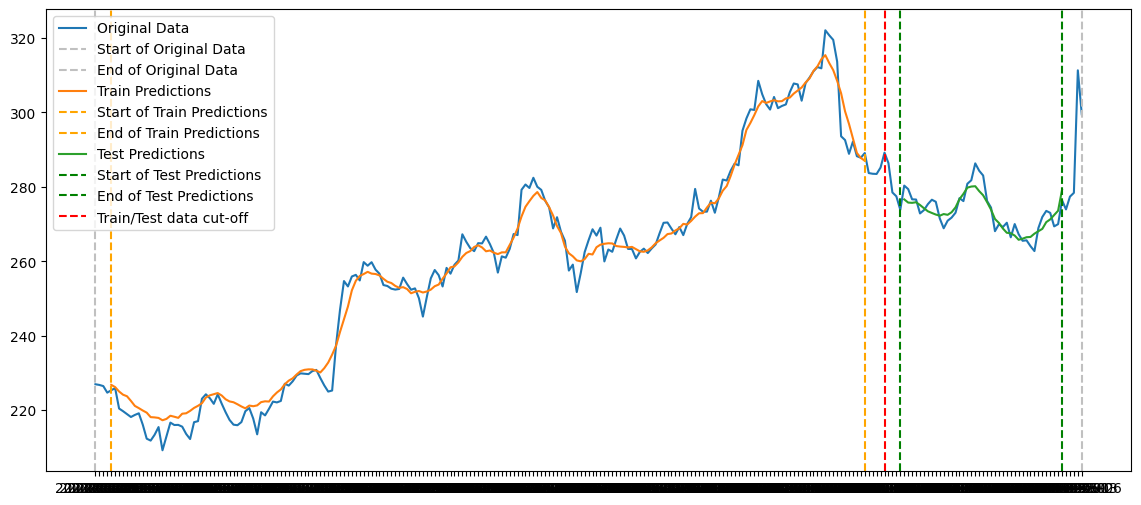

Differences in days: [4, 280, 7, 6, 61, 6]


/home/andrelfnovaes/miniconda3/envs/holistic-ai/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Train Score: 7.22 RMSE
Test Score: 8.37 RMSE

(8, 0)


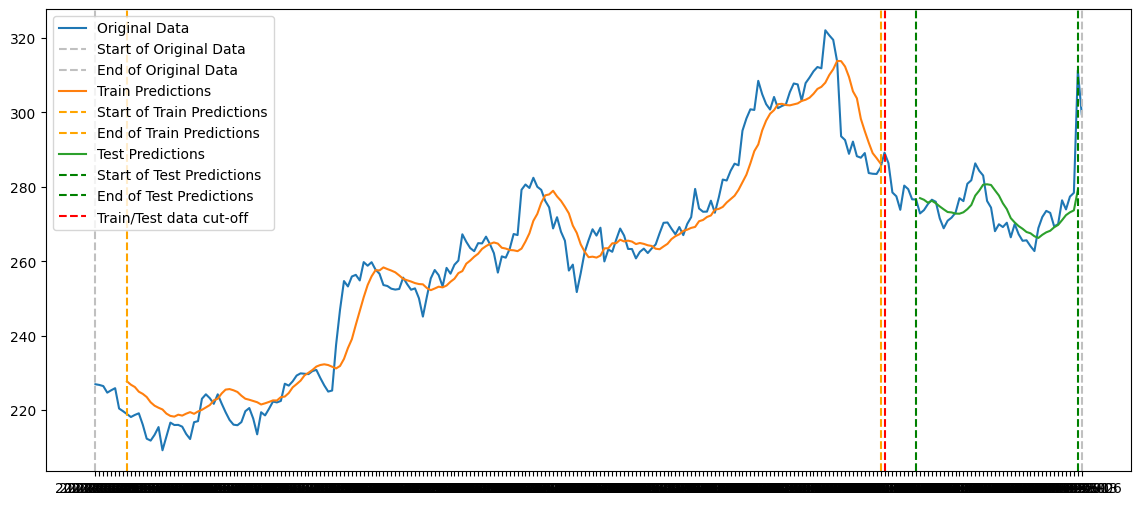

Differences in days: [10, 281, 0, 12, 61, 0]


In [1]:
import yfinance as yf  # Import yfinance for stock data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense

from datetime import datetime

# Parameters
djia_tickers = ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT', 'DIS']
time_horizon = '1y'
ticker = 'AMGN'
train_test_split = 0.8

# Load
data_original = pd.read_csv('data_original_djia.csv', index_col=0)
data_original = data_original[ticker]

# Create dataset function
def create_dataset(dataset, look_back, look_front):
    X, Y = [], []
    for i in range(look_back, len(dataset) - look_front):
        a = dataset[i - look_back:i, 0]
        b = dataset[i:i + look_front, 0]
        X.append(np.concatenate((a, b)))
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

window_btf = 4

# Experiments
for look_back, look_front in [window_btf, window_btf], [2*window_btf, 0]:

    # Preprocess the Data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data_original.values.reshape(-1, 1))

    # Define training and testing size
    train_size = int(len(data) * train_test_split)
    test_size = len(data) - train_size

    # Split the data
    train, test = data[0:train_size,:], data[train_size:len(data),:]

    # Reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back, look_front)
    testX, testY = create_dataset(test, look_back, look_front)

    # Reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # Step 3: Build the LSTM Model
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, look_back+look_front)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Step 4: Train the Model
    model.fit(trainX, trainY, epochs=10, batch_size=10, verbose=0)

    # Step 5: Make Predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # Calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    print(f'\n{(look_back, look_front)}')

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #
    # Plotting

    # Indexes
    train_start_index = look_back
    train_end_index = train_start_index + len(trainPredict)

    test_start_index = len(trainPredict) + (2*look_back)+look_front
    test_end_index = test_start_index + len(testPredict)-1

    # Shift train predictions for plotting
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[train_start_index : train_end_index, :] = trainPredict

    # Shift test predictions for plotting
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[test_start_index-1 : test_end_index, :] = testPredict

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # Get the dates from the original data
    dates = data_original.index

    # Plot baseline and predictions
    plt.figure(figsize=(14, 6))
    plt.plot(dates, scaler.inverse_transform(data), label='Original Data')

    # Add vertical lines at the beginning and end of the original data
    plt.axvline(x=dates[0], color='silver', linestyle='--', label='Start of Original Data')
    plt.axvline(x=dates[-1], color='silver', linestyle='--', label='End of Original Data')

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # Train predictions
    plt.plot(dates[train_start_index : train_end_index], 
            trainPredictPlot[train_start_index : train_end_index], 
            label='Train Predictions')

    plt.axvline(x=dates[train_start_index], color='orange', linestyle='--', label='Start of Train Predictions')
    plt.axvline(x=dates[train_end_index-1], color='orange', linestyle='--', label='End of Train Predictions')

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # Test predictions
    plt.plot(dates[test_start_index+1 : test_end_index+1], 
            testPredictPlot[test_start_index+1 : test_end_index+1], 
            label='Test Predictions')

    plt.axvline(x=dates[test_start_index], color='green', linestyle='--', label='Start of Test Predictions')
    plt.axvline(x=dates[test_end_index-1], color='green', linestyle='--', label='End of Test Predictions')

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    # Add a vertical line at the end of the training data
    plt.axvline(x=dates[train_size], color='red', linestyle='--', label='Train/Test data cut-off')

    plt.legend()
    plt.show()

    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - #

    dates_list = [
        dates[0], 
        dates[train_start_index], 
        dates[train_end_index], 
        dates[train_size], 
        dates[test_start_index],
        dates[test_end_index],
        dates[-1]
    ]

    # Convert the dates to datetime objects
    dates_list = [datetime.strptime(date, "%Y-%m-%d") for date in dates_list]

    # Calculate the differences
    differences = np.diff(dates_list)

    # Convert timedelta objects to days
    differences_in_days = [diff.days for diff in differences]

    print("Differences in days:", differences_in_days)
